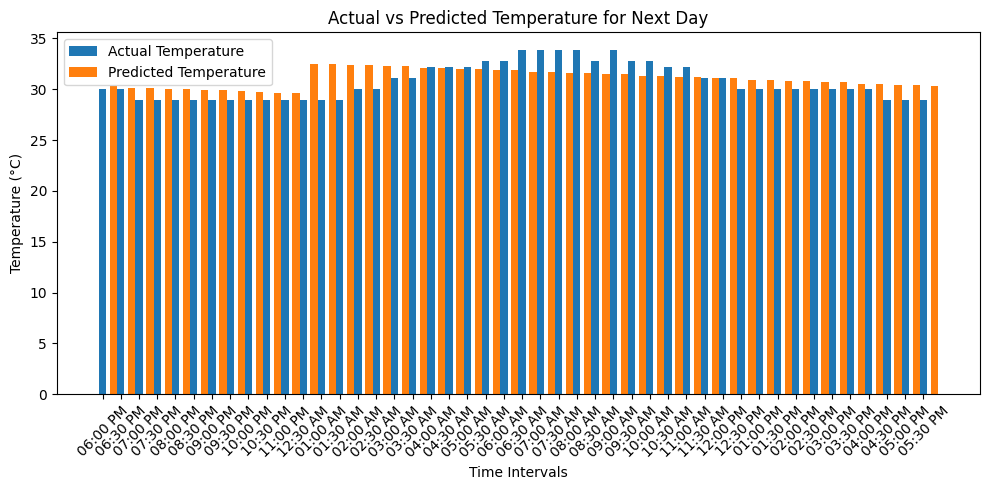

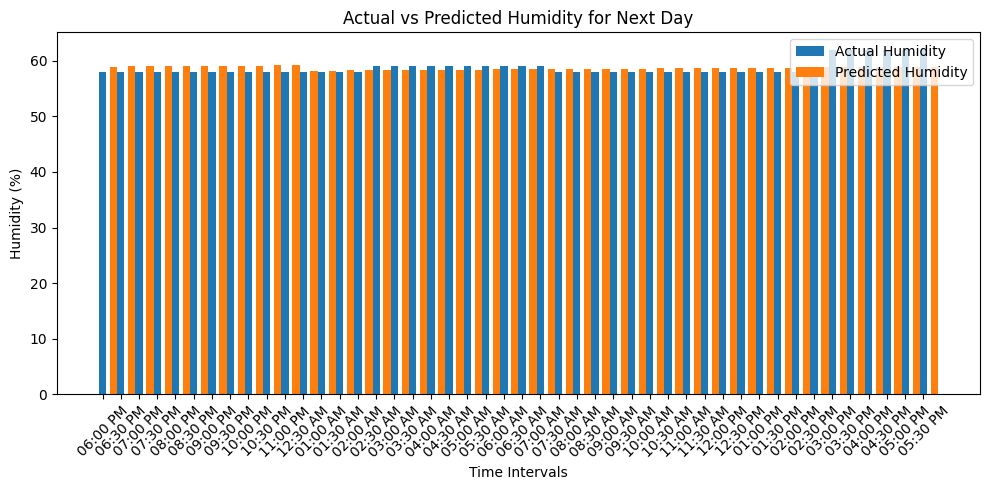

Predicted Values:
        Time  Temperature   Humidity
0   06:00 PM    30.293725  58.929093
1   06:30 PM    30.167652  58.970064
2   07:00 PM    30.164228  58.970680
3   07:30 PM    30.038155  59.011651
4   08:00 PM    30.034731  59.012268
5   08:30 PM    29.908658  59.053239
6   09:00 PM    29.905234  59.053855
7   09:30 PM    29.779160  59.094826
8   10:00 PM    29.775737  59.095443
9   10:30 PM    29.649663  59.136414
10  11:00 PM    29.646240  59.137030
11  12:30 AM    32.498600  58.221488
12  01:00 AM    32.495176  58.222105
13  01:30 AM    32.369103  58.263076
14  02:00 AM    32.365679  58.263693
15  02:30 AM    32.239606  58.304663
16  03:00 AM    32.236182  58.305280
17  03:30 AM    32.110109  58.346251
18  04:00 AM    32.106685  58.346868
19  04:30 AM    31.980612  58.387839
20  05:00 AM    31.977188  58.388455
21  05:30 AM    31.851114  58.429426
22  06:00 AM    31.847691  58.430043
23  06:30 AM    31.721617  58.471014
24  07:00 AM    31.718194  58.471630
25  07:30 AM    31.5

In [2]:
import pandas as pd
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import joblib

# Load the data and preprocess as before (assuming you have already done this)
data = pd.read_csv("dataset.csv", encoding='latin1')
data['Hour'] = pd.to_datetime(data['Time'], format='%I:%M %p').dt.hour
data['Minute'] = pd.to_datetime(data['Time'], format='%I:%M %p').dt.minute
data['Temperature'] = data['Temperature'].str.replace('°C', '').astype(float)
data['Humidity'] = data['Humidity'].str.replace('%', '').astype(float)

# Define time intervals for the next day
time_intervals = ['6:00 PM', '6:30 PM', '7:00 PM', '7:30 PM', '8:00 PM', '8:30 PM', '9:00 PM', '9:30 PM',
                  '10:00 PM', '10:30 PM', '11:00 PM', '12:30 AM', '1:00 AM', '1:30 AM', '2:00 AM',
                  '2:30 AM', '3:00 AM', '3:30 AM', '4:00 AM', '4:30 AM', '5:00 AM', '5:30 AM', '6:00 AM',
                  '6:30 AM', '7:00 AM', '7:30 AM', '8:00 AM', '8:30 AM', '9:00 AM', '9:30 AM', '10:00 AM',
                  '10:30 AM', '11:00 AM', '11:30 AM', '12:00 PM', '12:30 PM', '1:00 PM', '1:30 PM', '2:00 PM',
                  '2:30 PM', '3:00 PM', '3:30 PM', '4:00 PM', '4:30 PM', '5:00 PM', '5:30 PM']

# Generate the time points for the next day
next_day_times = [datetime.strptime(time, '%I:%M %p') + timedelta(days=1) for time in time_intervals]

# Train linear regression models for temperature and humidity prediction
temp_model = LinearRegression()
humidity_model = LinearRegression()

X_temp = data[['Hour', 'Minute']]
y_temp = data['Temperature']
X_humidity = data[['Hour', 'Minute']]
y_humidity = data['Humidity']

temp_model.fit(X_temp, y_temp)
humidity_model.fit(X_humidity, y_humidity)

# Save the trained models
joblib.dump(temp_model, 'temp_model.pkl')
joblib.dump(humidity_model, 'humidity_model.pkl')

# Function to make predictions on new data and generate graphs
def predict_and_plot_temperature_humidity(new_data):
    # Load the trained models
    temp_model = joblib.load('temp_model.pkl')
    humidity_model = joblib.load('humidity_model.pkl')
    
    # Preprocess the new data
    new_data['Hour'] = pd.to_datetime(new_data['Time'], format='%I:%M %p').dt.hour
    new_data['Minute'] = pd.to_datetime(new_data['Time'], format='%I:%M %p').dt.minute
    
    # Predict temperature and humidity for each time point
    next_day_predictions = []
    actual_temperatures = []
    actual_humidity = []
    for time_point in next_day_times:
        X_next_day = pd.DataFrame({'Hour': [time_point.hour], 'Minute': [time_point.minute]})
        next_day_temp_pred = temp_model.predict(X_next_day)
        next_day_humidity_pred = humidity_model.predict(X_next_day)
        next_day_predictions.append({'Time': time_point.strftime('%I:%M %p'),
                                     'Temperature': next_day_temp_pred[0],
                                     'Humidity': next_day_humidity_pred[0]})
        
        # Get actual values from the dataset
        actual_temp = data[(data['Hour'] == time_point.hour) & (data['Minute'] == time_point.minute)]['Temperature'].values
        actual_humid = data[(data['Hour'] == time_point.hour) & (data['Minute'] == time_point.minute)]['Humidity'].values
        if len(actual_temp) > 0 and len(actual_humid) > 0:  # Ensure data is available for this time point
            actual_temperatures.append(actual_temp[0])
            actual_humidity.append(actual_humid[0])
        else:
            actual_temperatures.append(None)
            actual_humidity.append(None)
    
    # Convert predictions into DataFrame
    next_day_predictions_df = pd.DataFrame(next_day_predictions)
    
    # Plot bar graph for Temperature
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(next_day_times)), actual_temperatures, width=0.4, align='center', label='Actual Temperature')
    plt.bar([x + 0.4 for x in range(len(next_day_times))], next_day_predictions_df['Temperature'], width=0.4, align='edge', label='Predicted Temperature')
    plt.xlabel('Time Intervals')
    plt.ylabel('Temperature (°C)')
    plt.title('Actual vs Predicted Temperature for Next Day')
    plt.xticks(range(len(next_day_times)), [time.strftime('%I:%M %p') for time in next_day_times], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot bar graph for Humidity
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(next_day_times)), actual_humidity, width=0.4, align='center', label='Actual Humidity')
    plt.bar([x + 0.4 for x in range(len(next_day_times))], next_day_predictions_df['Humidity'], width=0.4, align='edge', label='Predicted Humidity')
    plt.xlabel('Time Intervals')
    plt.ylabel('Humidity (%)')
    plt.title('Actual vs Predicted Humidity for Next Day')
    plt.xticks(range(len(next_day_times)), [time.strftime('%I:%M %p') for time in next_day_times], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return next_day_predictions_df

# Example usage:
# Assuming 'new_data' is your new dataset with 'Time' column
new_data = pd.read_csv("newset.csv", encoding='latin1')
predictions = predict_and_plot_temperature_humidity(new_data)
print("Predicted Values:")
print(predictions)
